# Changes in sea-level extremes

In [97]:
import os,sys
import numpy as np
import scipy as sp
import matplotlib as mpl
from cmocean import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, zoomed_inset_axes
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap

In [98]:
import xarray as xr

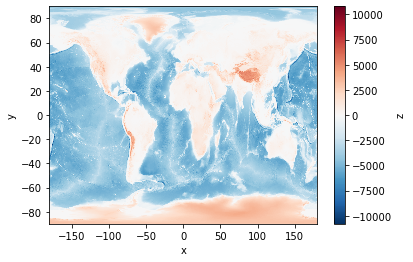

In [11]:
# Read ETOPO                                                                                                                
ds_etopo = xr.open_dataset('/data/user/jkjellsson/nemo-scripts/ETOPO2v2c_f4.nc').rename({'x':'lon', 'y':'lat'})
z_etopo  = ds_etopo['z']
z_etopo.plot()

## Read ocean model grid

In [120]:
# Read ocean model grid
file = '/data/user/jkjellsson/nemo-output/amm7/AMM7-EJK001/output/mesh_mask.nc'
ds_grid = xr.open_dataset(file)

## Define plot functions

In [118]:
def plot_NEED(ax, lon, lat, zdata, vmin=0, vmax=1, ctr=np.array([]), ctr_levs=np.array([]), region='amm_balt',lcb=True, uvel=np.array([]), vvel=np.array([])):
    """
    """
    # Read ETOPO                                                                     
    nc = Dataset('/data/user/jkjellsson/nemo-scripts/ETOPO2v2c_f4.nc','r')
    stride = 4
    tlon = nc.variables['x'][::stride]
    tlat = nc.variables['y'][::stride]
    etopo = nc.variables['z'][::stride,::stride]
    nc.close()
    
    if region == 'amm_balt':
        bm = Basemap(projection='cyl',llcrnrlon=-15,llcrnrlat=47,urcrnrlon=35,urcrnrlat=66,
                     ax=ax,fix_aspect=False)
    elif region == 'full':
        bm = Basemap(projection='cyl',llcrnrlon=-50,llcrnrlat=30,urcrnrlon=50,urcrnrlat=75,
                     ax=ax,fix_aspect=False)
    elif region == 'amm7':
        # This is the projection we use for most plots in the paper                   
        lon0=-10
        lat0=45
        lon1=12.5
        lat1=63
        bm = Basemap(projection='stere',llcrnrlon=lon0,llcrnrlat=lat0,urcrnrlon=lon1,
                     urcrnrlat=lat1,lon_0=0.5*(lon0+lon1),lat_0=0.5*(lat0+lat1),
                     lat_ts=0.5*(lat0+lat1),ax=ax,fix_aspect=True,resolution='i')

    tlon,tlat = np.meshgrid(tlon,tlat)
    tx,ty = bm(tlon,tlat)
    
    bg = 'etopo_lines'
    if bg == 'etopo':
        cmap = cm.cmap_d['topo']
        topo_lev = np.arange(-2500,2500,101)
        cf = bm.contourf(tx,ty,etopo,levels=topo_lev,cmap=cmap,extend='both',zorder=1)
    
    elif bg == 'etopo_lines':
        #cmap = cm.cmap_d['topo']                                                     
        cmap = plt.cm.YlGn
        #cmap = plt.cm.gist_earth                                                     
        topo_lev = np.arange(0,2000,101)
        clevels_norm = np.linspace(0.1,1,topo_lev.shape[0]+1)
        ccolors_norm = cmap(clevels_norm)
        cf = bm.contourf(tx,ty,etopo,levels=topo_lev,colors=ccolors_norm,
                         extend='both',zorder=1,alpha=1)
        bm.drawcoastlines(color='black',zorder=3,linewidth=0.5)
        bm.drawcountries(color='gray',linewidth=1)
        #bm.drawrivers(color='aqua',linewidth=0.2)                                    
        bm.drawmapboundary()
        #bm.readshapefile('/Users/jkjellsson/Downloads/europe/eurivs','eurivs') 
    
    elif bg == 'etopo_img':
        #bm.etopo(scale=1)                                                            
        #bm.shadedrelief(scale=1)                                                     
        #bm.warpimage(scale=1)                                                        
        #bm.warpimage('/Users/jkjellsson/Downloads/world.200412.3x5400x2700.jpg')     
        bm.warpimage('/Users/jkjellsson/Downloads/world.topo.200405.3x5400x2700.jpg')
        bm.drawcountries(color='white',linewidth=0.5)
    else:
        bm.fillcontinents(color='Gainsboro')
        bm.drawcoastlines()
        bm.drawcountries()
        bm.drawrivers(linewidth=0.1)

    if 1:
        levels = np.linspace(vmin,vmax,21)
    if lon.ndim == 1:
        lon2,lat2 = np.meshgrid(lon,lat)
        x,y = bm(lon2,lat2)
    else:
        x,y = bm(lon,lat)
        
    if vmin == -vmax:
        cmap = cm.cmap_d['balance']
        extend = 'both'
    else:
        cmap = cm.cmap_d['thermal']
        extend = 'max'

    x = x#.flatten()                                                                 
    y = y#.flatten()                                                                 
    z = zdata#.flatten()
    
    if 1:
        clevels_norm = np.linspace(0,1,levels.shape[0]+1)
        ccolors_norm = cmap(clevels_norm)
        cf = bm.contourf(x,y,z,levels=levels,colors=ccolors_norm,
                         extend=extend,zorder=2)
    if lcb:
        cbaxes = inset_axes(ax, width="5%", height="15%", loc=4,
                            bbox_to_anchor=(0., 0.05, 1, 0.95), bbox_transform=ax.transAxes)
        cb = plt.colorbar(cf,cax=cbaxes, orientation='vertical')
        print('plot_need: levels',levels)
        cb.set_ticks([levels[0],levels[int(levels.shape[0]/2)],levels[-1]])
        ticks_font = mpl.font_manager.FontProperties(family='times new roman', 
                                                     style='normal', size=12, 
                                                     weight='bold', stretch='normal')
        cb.set_ticklabels(['%1.1f' % (levels[0],),'[m]','%1.1f' % (levels[-1],)]) 
        cbaxes.yaxis.set_ticks_position("left")
        for label in cb.ax.get_yticklabels():
            label.set_fontproperties(ticks_font)
            
    else:
        cb = None
        
    if uvel.shape[0] > 0 and vvel.shape[0] > 0:
        narrows = 21
        # interpolate to regular grid                                                 
        lon1d = np.arange(-20,13,1/12.)
        lat1d = np.arange(40,65,1/12.)
        lon2d,lat2d = np.meshgrid(lon1d,lat1d)
        ureg = interp(lon,lat,uvel,lon2d,lat2d)
        vreg = interp(lon,lat,vvel,lon2d,lat2d)
        # interpolate to axes grid                                                    
        u,v,xv,yv = bm.transform_vector(ureg,vreg,lon1d,lat1d,narrows,narrows,
                                        returnxy=True,masked=False)
        # mask where 0                                                                
        umask = np.where(np.sqrt(u**2 + v**2)>0,1,0)
        u = np.ma.masked_where(umask==0,u)
        v = np.ma.masked_where(umask==0,v)
        # draw arrows                                                                 
        qv = bm.quiver(xv,yv,u,v,zorder=2,scale=2)
        # legend                                                                      
        xp = lon1 - 5
        yp = lat0 + 1
        print('loc',xp,yp)
        xp,yp = bm(xp,yp)
        xp = 0.8
        yp = 0.1
        print('loc',xp,yp)
        ax.quiverkey(qv, X=xp, Y=yp, U=0.1, coordinates='axes', 
                     label='0.1 m/s', labelpos='E')
    if ctr.shape[0] > 0:
        ct = bm.contour(x,y,ctr,levels=ctr_levs,colors='black',zorder=3)
        plt.clabel(ct, inline=1, fontsize=10, fmt='%1.1f')
        return cf,cb,ct
    else:
        return cf,cb

In [101]:
def calculate_bsf_v(v3d,dx,dz):
    """
    Calculate barotropic stream function from meridional velocities
    """
    
    nz,ny,nx = v3d.shape
    
    # Integrate verically 
    v3d[np.isnan(v3d)] = 0.
    dz[np.isnan(dz)] = 0.
    v_vint = np.ma.sum( v3d * dz, axis=0 )
    
    #fig, ax = plt.subplots(1,2)
    #ax[0].pcolormesh(v3d[0,:,:])
    #ax[1].pcolormesh(dz[0,:,:])
    
    # Integrate v * dx zonally
    # and scale to Sverdrup = 1e6 m3/s
    v_vint[v_vint.mask] = 0.
    v_vint = np.array(v_vint)
    bsf_v = -v_vint[:,:] * dx / 1e6
    bsf_v[v_vint == 0] = 0.
    for ji in range(nx-2,-1,-1):
        bsf_v[:,ji] += bsf_v[:,ji+1]
    
    #fig, ax = plt.subplots(1,3)
    #ax[0].pcolormesh(v_vint)
    #ax[1].pcolormesh(bsf_v)
    #ax[2].pcolormesh(dx)
    
    #bsf_v = np.ma.masked_where(v_vint == 0, bsf_v)
    
    return bsf_v

## Which runs to use?

* AMM7-EJK001: Control run
* AMM7-EJK002: With NEED
* AMM7-MJK004: SED and half NED
* AMM7-MJK005: Open English Channel + half NED

In [102]:
# AMM7 - configuration
# EJK - ECMWF (Reading) Joakim Kjellsson
# MJK - Mistral (Hamburg) Joakim Kjellsson
# 001 - Experiment ID

runs = ['AMM7-EJK001','AMM7-EJK002','AMM7-MJK004','AMM7-MJK005']
names = ['Present','NEED','SED + Half NED','Half NED']

## Read 95th percentile SSH

Pre-computed using Climate Data Operators (CDO). Data was detrended using the "detrend" function, and 95th percentile was calculated using "timpctl,95" function. 

In [103]:
ds_95 = []
for run in runs:
    file = '/data/user/jkjellsson/nemo-output/amm7/%s/output/%s_1h_19810101_19811231_grid_T_detrend_pctl_95.nc*' % (run,run)
    ds = xr.open_mfdataset(file,combine='by_coords')
    ds_95.append(ds)

In [104]:
ds_v = []
for run in runs:
    file = '/data/user/jkjellsson/nemo-output/amm7/%s/output/%s_5d_19810101_19811231_grid_V.nc*' % (run,run)
    ds = xr.open_mfdataset(file,combine='by_coords')
    ds_v.append(ds)

Present


/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


[0.2 2. ]
NEED


/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


[0.2 2. ]
SED + Half NED


/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


[0.2 2. ]
Half NED


/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/jkjellsson/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


[0.2 2. ]


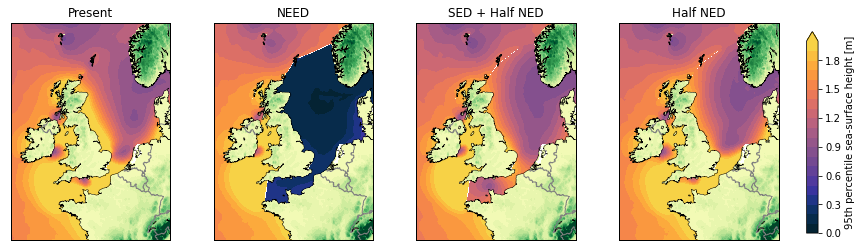

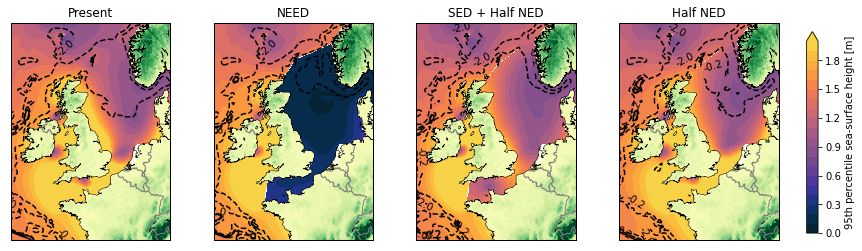

In [119]:
fig1, axs1 = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
ax1 = axs1.flat

fig2, axs2 = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
ax2 = axs2.flat

fig1.subplots_adjust(right=0.8)
cax1 = fig1.add_axes([0.82, 0.15, 0.01, 0.7])

fig2.subplots_adjust(right=0.8)
cax2 = fig2.add_axes([0.82, 0.15, 0.01, 0.7])

for i in range(0,4):
    ax = ax1[i]
    a2 = ax2[i]
    ds95 = ds_95[i]
    dsv  = ds_v[i]
    name = names[i]
    print(name)
    ax.set_title('%s' % (name,))
    a2.set_title('%s' % (name,))
    
    lon = ds95['nav_lon'].values
    lat = ds95['nav_lat'].values
    ssh = ds95['sossheig'][0,:,:].values
    v   = dsv['vomecrty'][:,:,:,:].values
    dx  = ds_grid['e1v'][0,:,:].values
    dz  = ds_grid['e3v_0'][0,:,:,:].values
    
    bsf_v_mean = 0
    for jn in range(0,v.shape[0]):
        bsf_v = calculate_bsf_v(v[jn,:,:,:],dx,dz)
        bsf_v_mean += bsf_v / float(v.shape[0])
    
    lcb = False
    vmin = 0.
    vmax = 2
    cf1,cb1 = plot_NEED(ax,lon,lat,ssh,vmin=vmin,vmax=vmax,region='amm7',lcb=lcb)
    
    tmp = np.array([])
    for x in range(-2,1):
        for y in [1,5]:
            tmp = np.append(tmp,int(y)*10**int(x))
    tmp = np.array([0.2,2])
    print(tmp)
    cflevels = np.concatenate((-tmp[::-1],tmp[:]),axis=0)
    bsf_levels = cflevels
    cf2,cb2,ct2 = plot_NEED(a2,lon,lat,ssh,vmin=vmin,vmax=vmax,region='amm7',lcb=lcb,ctr=bsf_v_mean,ctr_levs=bsf_levels)
    
    if i == 0:
        cb1 = fig1.colorbar(cf1, cax=cax1)
        cb1.set_label('95th percentile sea-surface height [m]')
        
        cb2 = fig2.colorbar(cf2, cax=cax2)
        cb2.set_label('95th percentile sea-surface height [m]')

# High-res PNG
fig1.savefig('95th_percentile_ssh.png',format='png',dpi=600)
fig2.savefig('95th_percentile_ssh_with_bsf.png',format='png',dpi=600)
# EPS, but this is heavy
#fig1.savefig('95th_percentile_ssh.eps',format='eps')